# Fine-tuning OpenCLIP on a Hugging Face image–text dataset (ViT-B-32)

This notebook shows an end-to-end, **single-GPU** fine-tuning run of an OpenCLIP model (`ViT-B-32`) on a **Hugging Face image–text dataset**.

**Dataset used:** `keremberke/food-101-with-captions` (easy to download, already has captions).

You can swap the dataset with another HF dataset that has an `image` column and a `caption`/`text` column.


In [55]:
import os
import random
import math
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import get_linear_schedule_with_warmup
from PIL import Image
from tqdm.auto import tqdm
import open_clip
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [21]:
# Setup Device
print('torch:', torch.__version__)
print('cuda available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('Using device:', device)

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

torch: 2.5.1+cu121
cuda available: True
NVIDIA GeForce RTX 2070 SUPER
Using device: cuda


## Load a dataset from Hugging Face

We'll use a **small subset** by default so it runs quickly. Increase `train_samples` and `eval_samples` if you want.


In [3]:
dataset_id = "nlphuji/flickr30k"
print(f"Loading dataset: {dataset_id}")
ds = load_dataset(dataset_id)
ds

Loading dataset: nlphuji/flickr30k


DatasetDict({
    test: Dataset({
        features: ['image', 'caption', 'sentids', 'split', 'img_id', 'filename'],
        num_rows: 31014
    })
})

In [4]:
print(ds['test'].column_names)
sample = ds['test'][0]
sample

['image', 'caption', 'sentids', 'split', 'img_id', 'filename']


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'caption': ['Two young guys with shaggy hair look at their hands while hanging out in the yard.',
  'Two young, White males are outside near many bushes.',
  'Two men in green shirts are standing in a yard.',
  'A man in a blue shirt standing in a garden.',
  'Two friends enjoy time spent together.'],
 'sentids': ['0', '1', '2', '3', '4'],
 'split': 'train',
 'img_id': '0',
 'filename': '1000092795.jpg'}

In [ ]:
# Split with no overlap using indices
train_hf = ds['test'].filter(lambda x: x["split"] == "train")
val_hf   = ds['test'].filter(lambda x: x["split"] == "val")   # sometimes "val" or "validation"
test_hf  = ds['test'].filter(lambda x: x["split"] == "test")

print(len(train_hf), len(val_hf), len(test_hf))
print(train_hf[0]["split"], val_hf[0]["split"], test_hf[0]["split"])

Filter:   0%|          | 0/31014 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31014 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31014 [00:00<?, ? examples/s]

29000 1014 1000
train val test
Train size: 10000, Eval size: 1000, Test size: 20014


## Create the OpenCLIP model + tokenizer


In [59]:
# Configuration
batch_size = 16 if device == 'cuda' else 16
epochs = 3 # Increased slightly as we have better optimization
lr = 5e-6
weight_decay = 0.0

In [60]:
# Model & Tokenizer
model_name = 'ViT-B-32'
pretrained = 'openai' #'laion2b_s34b_b79k'
model, train_preprocess, val_preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)
model = model.to(device)
model.train()

with torch.no_grad():
    model.logit_scale.fill_(np.log(1/0.07)) # Reset to ~14.3 to see if it moves (100 is often max/saturated)
model.logit_scale.requires_grad_(False)
print(f"Logit Scale with value {model.logit_scale.item()} requires_grad: {model.logit_scale.requires_grad}")


# PREVENT OVERFITTING: Freeze the Vision Encoder
# The dataset (2k images) is too small to fine-tune the heavy ViT backbone.
# We will only train the Text Encoder to align with the frozen images.
for param in model.visual.parameters():
    param.requires_grad = False

# LINEAR PROBING: Freeze the Text Transformer Backbone
# We only train the final projection steps to adapt the class embeddings.
# unfreeze last 2 blocks
for block in model.transformer.resblocks:
    for p in block.parameters():
        p.requires_grad = False

# Ensure Head is Trainable
model.text_projection.requires_grad_(True)
model.ln_final.requires_grad_(False)

# optional (I'd turn it OFF initially)
model.token_embedding.requires_grad_(False)
model.positional_embedding.requires_grad_(False)

model

c:\Users\jorge\Desktop\ComputerVisionProjects\finetuning-CLIP\.venv\Lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


Logit Scale with value 2.6592600345611572 requires_grad: False


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

Let's check first how the pretrained model performs on a sample of the dataset

In [61]:
for n,p in model.named_parameters():
    if p.requires_grad:
        print(n)

text_projection


Text: ['The cheerleader in red and white is sitting on the knee of a man also wearing red and white.', 'A female cheerleader sits on the knee of a male cheerleader.', 'A boy cheerleader has a girl cheerleader on his knee.', 'Two cheerleaders are sitting at a football game.', 'Cheerleaders taking a break']
Similarity: [[0.33680972]
 [0.3790024 ]
 [0.32933378]
 [0.31194314]
 [0.28452092]]


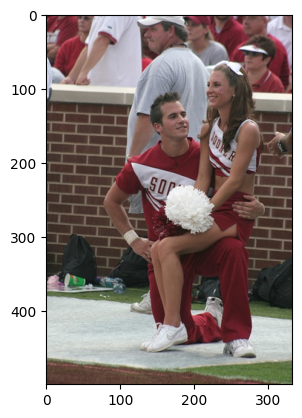

In [62]:
# image = Image.open("./examples/5.jfif").convert("RGB")
sample = test_split[0]
image = sample['image'].convert("RGB")
image_pre = val_preprocess(image)

text = sample['caption']

image_input = torch.tensor(np.expand_dims(image_pre, axis=0)).to(device)
text_tokens  = tokenizer(text).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

    # Normalize -> cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)

    # Similarity scores 
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

plt.imshow(image)
print("Text:", text)
print("Similarity:", similarity)

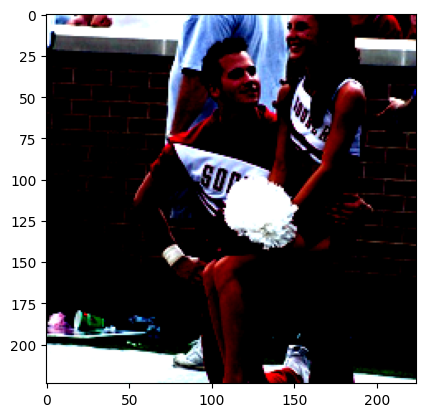

In [63]:
plt.imshow(image_pre.permute(1, 2, 0).numpy())

## Build a PyTorch Dataset + collate function


In [64]:
class FlickrOneCapTrain(Dataset):
    def __init__(self, hf_split):
        self.ds = hf_split

    def __len__(self): return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"].convert("RGB")
        cap = random.choice(ex["caption"])  # random each call
        return img, str(cap)

class FlickrOneCapEval(Dataset):
    def __init__(self, hf_split):
        self.ds = hf_split

    def __len__(self): return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"].convert("RGB")
        cap = ex["caption"][0]              # deterministic
        return img, str(cap)

def train_collate_fn(batch):
    images, texts = zip(*batch)
    image_t = torch.stack([train_preprocess(im) for im in images], dim=0)
    text_t  = tokenizer(list(texts))
    return image_t, text_t.long()
    
def eval_collate_fn(batch):
    images, texts = zip(*batch)
    image_t = torch.stack([val_preprocess(im) for im in images], dim=0)
    text_t  = tokenizer(list(texts))
    return image_t, text_t.long()

train_ds = FlickrOneCapTrain(train_hf)
eval_ds  = FlickrOneCapEval(val_hf)
test_ds  = FlickrOneCapEval(test_hf)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0,
                          pin_memory=(device=='cuda'), collate_fn=train_collate_fn)
eval_loader  = DataLoader(eval_ds,  batch_size=batch_size, shuffle=False, num_workers=0,
                          pin_memory=(device=='cuda'), collate_fn=eval_collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0,
                          pin_memory=(device=='cuda'), collate_fn=eval_collate_fn)

images_b, text_b = next(iter(train_loader))
images_b.shape, text_b.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 77]))

In [65]:
batch = next(iter(train_loader))
images, text = batch
print(type(text))
if torch.is_tensor(text):
    print("tensor", text.dtype, text.shape)
else:
    print("not tensor:", getattr(text, "keys", lambda: None)())

<class 'torch.Tensor'>
tensor torch.int64 torch.Size([16, 77])


## Loss + quick retrieval metric

We use the standard symmetric CLIP contrastive loss.


In [66]:
def clip_contrastive_loss(logits_per_image, logits_per_text):
    """
    Standard CLIP contrastive loss.

    logits_per_image: [B, B] matrix
        Entry (i, j) = similarity between image i and text j

    logits_per_text: [B, B] matrix
        Entry (i, j) = similarity between text i and image j
        (usually the transpose of logits_per_image)

    Goal:
    - image i should match text i (diagonal)
    - all other pairs are negatives
    """

    # Batch size (number of image-text pairs)
    bs = logits_per_image.shape[0]

    # Ground-truth labels: image i corresponds to text i
    # Example for bs=4: [0, 1, 2, 3]
    labels = torch.arange(bs, device=logits_per_image.device, dtype=torch.long)
    
    # Image → Text loss:
    # For each image row, the correct text is at index i
    loss_i = nn.CrossEntropyLoss()(logits_per_image, labels)

    # Text → Image loss:
    # For each text row, the correct image is at index i
    loss_t = nn.CrossEntropyLoss()(logits_per_text, labels)

    # Symmetric CLIP loss
    return (loss_i + loss_t) / 2
    

@torch.no_grad()
def retrieval_recall_at_k(model, loader, k=5, max_batches=10):
    """
    Computes retrieval Recall@K for:
    - Image → Text
    - Text → Image

    Only uses a small subset of the data (max_batches) for speed.
    """

    # Switch to eval mode (disable dropout, etc.)
    was_training = model.training
    model.eval()

    imgs_all, txts_all = [], []

    # Encode a limited number of batches
    for bi, (images, text) in enumerate(loader):
        if bi >= max_batches:
            break

        images = images.to(device)
        text   = text.to(device)

        # Encode images and texts separately
        image_features = model.encode_image(images)
        text_features  = model.encode_text(text)

        # Normalize → cosine similarity
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features  = text_features  / text_features.norm(dim=-1, keepdim=True)

        imgs_all.append(image_features)
        txts_all.append(text_features)

    if not imgs_all: return 0.0, 0.0

    # Concatenate all embeddings
    imgs = torch.cat(imgs_all, dim=0)  # [N, D]
    txts = torch.cat(txts_all, dim=0)  # [N, D]

    # Cosine similarity matrix
    # sims[i, j] = similarity(image_i, text_j)
    sims = imgs @ txts.T               # [N, N]

    # For each image, find top-K most similar texts
    topk = sims.topk(k, dim=1).indices  # [N, K]
    # Ground truth: image i should match text i
    targets = torch.arange(sims.shape[0], device=sims.device).unsqueeze(1)
    # Check if correct text index appears in top-K
    i2t = (topk == targets).any(dim=1).float().mean().item()

    # For each text, find top-K most similar images
    topk_t = sims.topk(k, dim=0).indices  # [K, N]
    # Ground truth: text i should match image i
    targets_t = torch.arange(sims.shape[1], device=sims.device).unsqueeze(0)
    # Check if correct image index appears in top-K
    t2i = (topk_t == targets_t).any(dim=0).float().mean().item()

    # Restore training mode
    if was_training:
        model.train()

    return i2t, t2i


@torch.no_grad()
def diag_offdiag_gap_one_batch(model, loader):
    was_training = model.training
    model.eval()
    images, text = next(iter(loader))
    images, text = images.to(device), text.to(device)

    img_f = model.encode_image(images)
    txt_f = model.encode_text(text)
    img_f = img_f / img_f.norm(dim=-1, keepdim=True)
    txt_f = txt_f / txt_f.norm(dim=-1, keepdim=True)

    sims = img_f @ txt_f.T
    diag = sims.diag().mean().item()
    off  = (sims.sum() - sims.diag().sum()).item() / (sims.numel() - sims.size(0))

    if was_training:
        model.train()
    return diag, off, diag - off

@torch.no_grad()
def batch_margins(model, loader):
    was_training = model.training
    model.eval()
    images, text = next(iter(loader))
    images, text = images.to(device), text.to(device)

    img_f = model.encode_image(images)
    txt_f = model.encode_text(text)
    img_f = img_f / img_f.norm(dim=-1, keepdim=True)
    txt_f = txt_f / txt_f.norm(dim=-1, keepdim=True)
    sims = img_f @ txt_f.T  # [B,B]

    B = sims.size(0)
    pos = sims.diag()

    # i2t: best negative per image
    neg_i2t = sims.masked_fill(torch.eye(B, device=sims.device).bool(), -1e9).max(dim=1).values
    margin_i2t = (pos - neg_i2t)

    # t2i: best negative per text
    neg_t2i = sims.masked_fill(torch.eye(B, device=sims.device).bool(), -1e9).max(dim=0).values
    margin_t2i = (pos - neg_t2i)

    # ranks
    rank_i2t = (sims > pos.unsqueeze(1)).sum(dim=1) + 1
    rank_t2i = (sims > pos.unsqueeze(0)).sum(dim=0) + 1

    if was_training:
        model.train()

    return {
        "i2t_top1": (rank_i2t == 1).float().mean().item(),
        "t2i_top1": (rank_t2i == 1).float().mean().item(),
        "i2t_margin_mean": margin_i2t.mean().item(),
        "t2i_margin_mean": margin_t2i.mean().item(),
    }

## Fine-tune


In [67]:
batch_margins(model, eval_loader)

{'i2t_top1': 1.0,
 't2i_top1': 1.0,
 'i2t_margin_mean': 0.08746353536844254,
 't2i_margin_mean': 0.08120264858007431}

In [68]:
# Training Loop
# Add Weight Decay Separation
# We only decay weights in Linear/Conv2d layers, NOT biases or LayerNorms.

exclude = lambda n, p: p.ndim < 2 or "bn" in n or "ln" in n or "bias" in n or 'logit_scale' in n
include = lambda n, p: not exclude(n, p)

named_parameters = list(model.named_parameters())
gain_or_bias_params = [p for n, p in named_parameters if exclude(n, p) and p.requires_grad]
rest_params = [p for n, p in named_parameters if include(n, p) and p.requires_grad]

optimizer = torch.optim.AdamW(
                    [
                        {"params": gain_or_bias_params, "weight_decay": 0.},
                        {"params": rest_params, "weight_decay": weight_decay},
                    ],
                    lr=lr,
                )

# We need a linear warmup to avoid "shocking" the pre-trained weights
accum_steps = 4
total_steps = math.ceil(len(train_loader) / accum_steps) * epochs
# scheduler = get_linear_schedule_with_warmup(
#     optimizer, 
#     num_warmup_steps=int(0.1 * total_steps), # 10% warmup
#     num_training_steps=total_steps
# )

scaler = torch.amp.GradScaler('cuda', enabled=(device=='cuda'))

print('Initial quick retrieval@5:', retrieval_recall_at_k(model, eval_loader, k=5, max_batches=50))

for epoch in range(epochs):
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
    running_loss = 0.0
    optimizer.zero_grad(set_to_none=True)
    for step, (images, text) in enumerate(pbar):
        images = images.to(device)
        text = text.to(device)

        with torch.amp.autocast('cuda', enabled=(device=='cuda')):
            logits_per_image, logits_per_text = model(images, text)[:2]
            loss = clip_contrastive_loss(logits_per_image,
                                         logits_per_text)

        running_loss += loss.item()
        scaler.scale(loss / accum_steps).backward()
        
        if (step + 1) % accum_steps == 0:
            # Gradient Clipping
            scaler.unscale_(optimizer)
            trainable_params = [p for p in model.parameters() if p.requires_grad]
            torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
            
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            # scheduler.step() # Step the scheduler
        
                       
        if (step+1) % 10 == 0:
            pbar.set_postfix({'loss': running_loss / 10})
            running_loss = 0.0

    # flush leftovers
    if (len(train_loader) % accum_steps) != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        # scheduler.step()

    i2t, t2i = retrieval_recall_at_k(model, eval_loader, k=5, max_batches=50)
    diag, off, gap = diag_offdiag_gap_one_batch(model, eval_loader)
    
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, text in eval_loader:
            images = images.to(device)
            text   = text.to(device)
            with torch.amp.autocast('cuda', enabled=(device=='cuda')):
                logits_per_image, logits_per_text = model(images, text)[:2]
                val_running_loss += clip_contrastive_loss(logits_per_image,
                                                          logits_per_text).item()

    val_loss_avg = val_running_loss / len(eval_loader)
    model.train()
    
    print(f'End of Epoch {epoch+1}: i2t={i2t:.6f}, t2i={t2i:.6f}, val_loss={val_loss_avg:.6f}')
    print(f"diag_sim={diag:.6f}, offdiag_sim={off:.6f}, gap={gap:.6f}")
    print("logit_scale:", float(model.logit_scale.exp().detach().cpu()))


Initial quick retrieval@5: (0.8974999785423279, 0.8812499642372131)


Epoch 1/3:   0%|          | 0/1813 [00:00<?, ?it/s]

End of Epoch 1: i2t=0.868750, t2i=0.740000, val_loss=6.208214
diag_sim=0.219066, offdiag_sim=0.104697, gap=0.114369
logit_scale: 14.285715103149414


Epoch 2/3:   0%|          | 0/1813 [00:00<?, ?it/s]

End of Epoch 2: i2t=0.856250, t2i=0.782500, val_loss=6.185041
diag_sim=0.196931, offdiag_sim=0.072301, gap=0.124631
logit_scale: 14.285715103149414


Epoch 3/3:   0%|          | 0/1813 [00:00<?, ?it/s]

End of Epoch 3: i2t=0.706250, t2i=0.728750, val_loss=6.157142
diag_sim=0.160410, offdiag_sim=0.052221, gap=0.108189
logit_scale: 14.285715103149414


Text: ['The cheerleader in red and white is sitting on the knee of a man also wearing red and white.', 'A female cheerleader sits on the knee of a male cheerleader.', 'A boy cheerleader has a girl cheerleader on his knee.', 'Two cheerleaders are sitting at a football game.', 'Cheerleaders taking a break']
Similarity: [[0.17997944]
 [0.25189167]
 [0.21685477]
 [0.20136017]
 [0.19387785]]


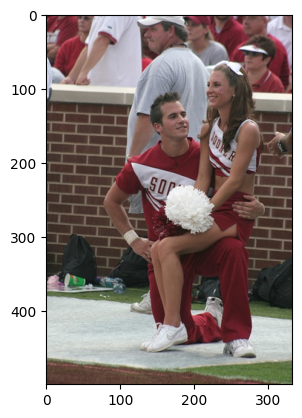

In [72]:
# image = Image.open("./examples/5.jfif").convert("RGB")
sample = test_split[0]
image = sample['image'].convert("RGB")
image_pre = preprocess(image)

text = sample['caption']

image_input = torch.tensor(np.expand_dims(image_pre, axis=0)).to(device)
text_tokens  = tokenizer(text).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

    # Normalize -> cosine similarity
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)

    # Similarity scores 
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

plt.imshow(image)
print("Text:", text)
print("Similarity:", similarity)

In [70]:
batch_margins(model, eval_loader)

{'i2t_top1': 1.0,
 't2i_top1': 0.9375,
 'i2t_margin_mean': 0.05483866482973099,
 't2i_margin_mean': 0.050294652581214905}

## Save checkpoint


In [71]:
print([n for n,p in model.named_parameters() if p.requires_grad])
print(set(ds["test"]["split"]))
print(len(train_hf), len(val_hf), len(test_hf))
print(train_hf[0]["split"], val_hf[0]["split"], test_hf[0]["split"])


['text_projection']
{'test', 'val', 'train'}
29000 1014 1000
train val test


In [ ]:
# Save
out_dir = './model'
os.makedirs(out_dir, exist_ok=True)
ckpt_path = os.path.join(out_dir, 'openclip_vitb32.pt')
torch.save({
    'state_dict': model.state_dict(), 
    'model_name': model_name, 
    'pretrained': pretrained
}, ckpt_path)
print(f"Saved model to {ckpt_path}")

Saved model to ./model\openclip_vitb32.pt


: 

## Reload later

In [23]:
# import torch, open_clip
# ckpt = torch.load('model/openclip_vitb32.pt', map_location='cpu')
# model, _, preprocess = open_clip.create_model_and_transforms(ckpt['model_name'], pretrained=ckpt['pretrained'])
# model.load_state_dict(ckpt['state_dict'])
# model = model.to(device)
# model.eval()



C:\Users\jorge\AppData\Local\Temp\ipykernel_10236\4275510273.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('model/openclip_vitb32.pt', map_location='

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine